In [207]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from saif.crs_model.peakdetector import pk_indxs
plt.style.use('ggplot')

%matplotlib inline

### Load Data

In [113]:
SEISMIC_DATA = '../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingSeismic.hdf5'
PRESSURE_DATA = '../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingPressure.hdf5'

In [114]:
from orion_light import seismic_catalog
from orion_light import pressure_table

In [115]:
catalog = seismic_catalog.SeismicCatalog()
catalog.load_catalog_hdf5(SEISMIC_DATA)

In [116]:
pressure_model = pressure_table.PressureTableModel()
pressure_model.load_table(PRESSURE_DATA)

Loading pressure table from hdf5 file: ../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingPressure.hdf5


### Process $N(t)$

- Pressure data and seismic events are recorded at different times.
    - First goal: Clip all data to the time interval where we have samples for both pressure and seismic activity
    - Second goal: linearly interpolate the seismic data so that the event times align with the pressure data.
    - Third goal: empirically compute the rate (numerical derivative), in order to define R0.
- Partition the data into **main shock** and **interseismic** regions.
    - This should be done by a peak detector, but right now it is done manually (by visual inspection).

In [117]:
from scipy.interpolate import interp1d

Obtain the time intervals for the seismic data, and creating the interpolator.

In [118]:
Mc = 1.6
catalog.set_slice(magnitude_range = [Mc, 10])
event_times = catalog.get_epoch_slice() 
start_t = event_times[0]
end_t = event_times[-1]
event_times = event_times / 86400 / 365.25

t_n = event_times - event_times[0]
n_cnts = np.arange(len(t_n))
n_func = interp1d(t_n, n_cnts, kind='linear')

Obtain the time intervals for the pressure data, and interpolate the seismic data

In [119]:
t_p = pressure_epoch = pressure_model.table_data['t']
start_idx = np.where(t_p > start_t)[0][0]
end_idx = np.where(t_p > end_t)[0][0] - 1

t_p = t_p[start_idx:end_idx]
p = pressure_model.table_data['pressure'][1:][start_idx+1:end_idx]
dpdt = pressure_model.table_data['dpdt'][1:][start_idx+1:end_idx]

delta_t = t_p[1:] - t_p[:-1]

p = torch.FloatTensor(p)
dpdt = torch.FloatTensor(dpdt)
delta_t = torch.FloatTensor(delta_t)

t_p_interpolated = t_p / 86400 / 365.25 - event_times[0]
n_interpolated = n_func(t_p_interpolated) # interpolated number of earthquakes 

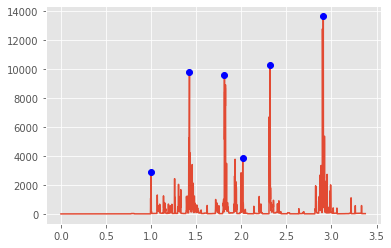

In [120]:
empirical_rate = np.gradient(n_interpolated, t_p_interpolated)
peak_indexs=pk_indxs(empirical_rate,trshd=0.2, min_dist=150)
plt.plot(t_p_interpolated, empirical_rate)
plt.plot(t_p_interpolated[peak_indexs],empirical_rate[peak_indexs],'o',color='b')

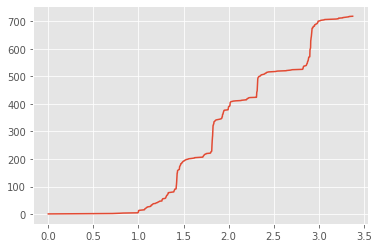

In [121]:
plt.plot(t_p_interpolated, n_interpolated)

Examining the first interseismic chunk (from t=0 years to t=1.3 years)

In [122]:
train_end = np.where(t_p_interpolated > 1.3)[0][0]

In [123]:
n_target = torch.FloatTensor(n_interpolated)[:train_end]
p = torch.FloatTensor(p)[:train_end]
dpdt = torch.FloatTensor(dpdt)[:train_end]
delta_t = torch.FloatTensor(delta_t)[:train_end]

### Define site constants

In [124]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400

site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item()
}

### Sampling the grid

We keep the rate factor fixed, and examine the landscape for mu_minus_alpha and rate_coeff.

In [125]:
params = torch.FloatTensor([[0.5,1e-2,1e-4]])

# Only for exploring the data, not ML model
 
# mu_minus_alpha_mesh = torch.linspace(0.1,1.0,101)
# rate_coeff_mesh = 10 ** torch.linspace(-4,-1,101)
# grid_mu, grid_rate = torch.meshgrid(mu_minus_alpha_mesh, rate_coeff_mesh, indexing='ij')

# params = torch.stack([
#     grid_mu.flatten(),
#     grid_rate.flatten(),
#     163.7424 / 1e6 * torch.ones_like(grid_rate.flatten()), # rate_factor 
# ]).T

# params.requires_grad_()



### Run Model

In [126]:
from saif.crs_model.model import CRSModel

In [127]:
model = CRSModel(site_info)

In [128]:
Rt, Nt = model(params, p, dpdt, delta_t)

In [129]:
Rt

tensor([[4.9332e-08, 4.9339e-08, 4.9347e-08,  ..., 3.2783e-07, 3.2878e-07,
         3.2973e-07]])

In [130]:
Nt.shape

torch.Size([1, 1415])

Visualize a sample

Define the criterion: MSELoss.

- Be careful: we may need to normalize the data before using MSELoss.
- In future, we might forecast rate (or, $\Delta N(t)$) since this is easier to bound than total number.

In [131]:
criterion = nn.MSELoss(reduction='sum')

In [146]:
loss = criterion(Nt[:,1:], n_target[None,:])
loss.item()

364191.0

In [291]:
import torch.optim as optim

# params = torch.FloatTensor([[0.5,1e-2,1e-4]])
params = torch.FloatTensor([[0.5,1e-2,1e-4]])
params.requires_grad=True #
params.register_hook(lambda g: F.normalize(g)) # some function that takes in gradients and adjusts it
# Here we use normalize from torch.functional

optimizer = optim.SGD(params=[params],lr=.0001,momentum=0.2)
# optimizer = optim.Adam(params=[params],lr=0.01)
criterion = nn.MSELoss(reduction='sum')

model = CRSModel(site_info)
Rt, Nt = model(params, p, dpdt, delta_t)

In [292]:
# display(params.grad.data)

In [293]:
for step in range(200):
    Rt, Nt = model(params, p, dpdt, delta_t)
    # loss = criterion(Nt[:,1:], n_target[None,:]) # Need to define a loss function that compares with the real data
    # Define a MSE of forecasted number Nt with the ground truth
    optimizer.zero_grad()
    loss = criterion(Nt[:,1:].squeeze(), n_target[:])
    # print('loss is ' + str(loss.item()))
    # optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (step % 20 == 0):
        print("step: " + str(step))
        print("loss is " + str(loss.item()))
        # display(params)
        # display(params.grad.data) # showing the gradient
    
    if (loss.item() < 10000):
        optimizer=optim.SGD(params=[params],lr=.00001,momentum=0.2) # reduce the learning rate when loss is small
    

step: 0
loss is 364191.0
step: 20
loss is 341763.75
step: 40
loss is 272521.28125
step: 60
loss is 22905.67578125
step: 80
loss is 7696.9892578125
step: 100
loss is 4535.482421875
step: 120
loss is 3597.325439453125
step: 140
loss is 3402.8603515625
step: 160
loss is 3324.949951171875
step: 180
loss is 3290.524658203125


In [294]:
# params_final = torch.FloatTensor([[5.0010e-01, 2.5500e-03, 1.5320e-04]]) # Final output
params_initial = torch.FloatTensor([[0.5,1e-2,1e-4]]) # Initialization
display(params)

tensor([[5.0010e-01, 2.4322e-03, 2.4004e-04]], requires_grad=True)

In [296]:
Rt, Nt = model(params, p, dpdt, delta_t)
loss = criterion(Nt[:,1:].squeeze(), n_target)
loss.data

tensor(3274.3108)

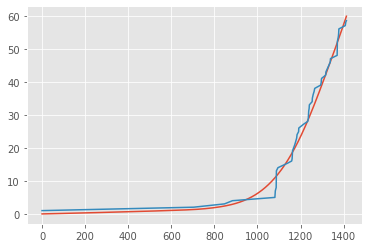

In [297]:
plt.plot(Nt[0,1:].detach().numpy())
plt.plot(n_target)

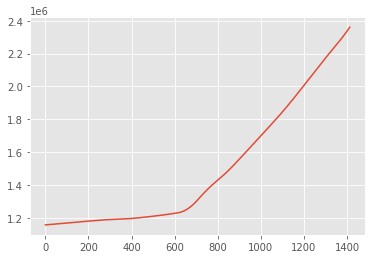

In [106]:
plt.plot(p)

In [298]:
params

tensor([[5.0010e-01, 2.4322e-03, 2.4004e-04]], requires_grad=True)